In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

## General Functions
Functions derived from cleaning the data

In [ ]:
## function to clean observation dataset before shifting the rainfall 3 hours back
def clean_obs_before(df):
    
    ## rename columns and remove whitespaces
    df.columns = df.columns.str.strip()
    df.rename(columns={'RAIN 1': 'RAIN1', 
                       'RAIN 2': 'RAIN2', 
                       'RPeriodi 1': 'RPeriod1', 
                       'RPeriod 2': 'RPeriod2', 
                       'TEMPERATR': 'TEMP',
                       'RELHUMIDY': 'RELHUMIDITY',
                       'VISIBLITY': 'VISIBILITY',}, inplace = True)
    

    ## replace -9999 with NaN values
    df.replace(-9999.0, np.nan, inplace = True)

    ## remove rows where date is invalid
    df.drop(df[(df.YYYY == 0) | (df.MM == 0) | (df.DD == 0)].index, inplace = True)
    
    ## remove rows where all values are null
    df.dropna(axis=0, subset=['TEMP'], inplace = True)

    ## convert date to datetime format
    df['TIME'] = df['YYYY'].map(str) + '-' + df['MM'].map(str) + '-' + df['DD'].map(str) + ':' + df['HH'].map(str)
    df['TIME'] = pd.to_datetime(df['TIME'], format = '%Y-%m-%d:%H')
    df.drop(['YYYY','MM','DD','HH','RECDNO'], axis = 1, inplace = True)
    
    ## move time to the first column
    cols = list(df.columns.values)
    cols = cols[-1:] + cols[:-1]
    df = df.loc[:,cols]
    
    ## remove RAIN1 and RPeriod1 (explanation made below)
    df.drop(['RAIN1', 'RPeriod1'], axis = 1, inplace = True)
    
    return df

In [ ]:
## function to shift rain observation back 3 hours
def shift_rain(df):
    ## Separating rainfall observation into another dataframe
    rain = df[['TIME','RAIN2','RPeriod2']]
    df.drop(['RAIN2','RPeriod2'], axis=1, inplace=True)

    ## create new date range for every 3 hours
    start = rain.TIME.min()
    end = rain.TIME.max()
    date_range = pd.date_range(start=start, end=end, freq='3H')
    date_range = pd.to_datetime(date_range)

    ## create new dataframe of just time and rain
    new_df = pd.DataFrame(date_range, columns=['TIME'])
    rain = pd.merge(new_df, rain[['TIME', 'RAIN2']], how='left', on='TIME')

    ## shift rainfall values up one row
    rain[['RAIN2']] = rain.RAIN2.shift(-1)
    
    ## merge rain back into original dataframe
    df = pd.merge(rain, df, how='left', on='TIME')
    
    ## remove columns where all values are null
#     df.dropna(axis=1, how='all', inplace = True)
    
    ## remove rows where the explanatory variables are null
    ## this happens when we shift the rain observation to a time where no data was recorded
    ## we would have only have the rain observation for that time and no variables to explain it
    df = df.interpolate(method='linear')
    
    ## fill remaining missing RAIN2 values with 0
    df.RAIN2.fillna(0, inplace= True)
    
    ## classify rain to be 1 if heavy rain and 0 if not
#     df['RAIN'] = [1 if x >= 1.5 else 0 for x in df['RAIN2']] 
    df.drop(['STATNO'], axis = 1, inplace = True)
    
#     ## remove pesky columns which still contains null values
#     col_to_drop = df.columns[df.isna().any()].tolist()
#     if (col_to_drop):
#         df.drop(col_to_drop, axis=1, inplace = True)
    
    return df

## Basic EDA
We will first look at the dataset as a whole by combining all the stations.

In [ ]:
df_all = pd.concat([pd.read_csv(f) for f in glob.glob("pmd_data/*hour.csv")], ignore_index = True)
df_all.rename(columns={' RAIN 1  ': 'RAIN1', 
                       ' RAIN 2   ': 'RAIN2', 
                       'RPeriodi 1': 'RPeriod1', 
                       'RPeriod 2': 'RPeriod2', 
                       'TEMPERATR': 'TEMP'}, inplace = True)
print(df_all.RPeriod1.value_counts())
print('')
print(df_all.RPeriod2.value_counts())

Combining the observation dataset from all stations and after cleaning and analysing them shows that most of the observation in RAIN2 is from the last 3 hours, while RAIN1 values are mostly spread out between 6, 12 and 18 hours. Instead of finding a method to combine RAIN1 and RAIN2, we could just use RAIN2 with RPeriod2 of 3.0. But before we do that, we first need to check how many among the 84,894 observations are null.

In [ ]:
df_test = df_all[df_all.RPeriod2 == 3.0]
print("Frequency of null values: ", (df_test.RAIN2 == -9999).sum(), df_test.shape)
print("Frequency of zero values: ", (df_test.RAIN2 == 0).sum())

There are 4,558 null observations out of 86,606 observations. Additionally, 77,361 observations are zero value, which is inline with the fact that rainfall is zero-inflated. Hence, to simplify the data wrangling process, we choose to only use the RAIN2 observation data with RPeriod2 of 3.0.

In [ ]:
df_all.drop(['RAIN1', 'RPeriod1'], axis = 1, inplace = True)

## Cleaning Data
Now we analyze only one station data and clean it.

In [ ]:
df = pd.read_csv('pmd_data/OBS_n41504_hour.csv')
df.head()

We need to clean up the data by
- renaming the columns
- removing whitespaces from the columns
- replace -9999 values with proper NaN values
- remove any invalid date rows
- remove any rows where all values are null
- merge 'YYYY', 'MM', 'DD', 'HH' into a pandas datetime format for easier handling
- using only RAIN2 as our target variable
- shifting rain values one row up
- impute any missing values by linear interpolation

In [ ]:
## rename columns and remove whitespaces
df.columns = df.columns.str.strip()
df.rename(columns={'RAIN 1': 'RAIN1', 
               'RAIN 2': 'RAIN2', 
               'RPeriodi 1': 'RPeriod1', 
               'RPeriod 2': 'RPeriod2', 
               'TEMPERATR': 'TEMP',
               'RELHUMIDY': 'RELHUMIDITY',
               'VISIBLITY': 'VISIBILITY',}, inplace = True)

## replace -9999 with NaN values
df.replace(-9999.0, np.nan, inplace = True)

## remove rows where date is invalid
df.drop(df[(df.YYYY == 0) | (df.MM == 0) | (df.DD == 0)].index, inplace = True)

## remove rows where all values are null
df.dropna(axis=0, subset=['TEMP'], inplace = True)

## convert date to datetime format
df['TIME'] = df['YYYY'].map(str) + '-' + df['MM'].map(str) + '-' + df['DD'].map(str) + ':' + df['HH'].map(str)
df['TIME'] = pd.to_datetime(df['TIME'], format = '%Y-%m-%d:%H')
df.drop(['YYYY','MM','DD','HH','RECDNO'], axis = 1, inplace = True)

## move time to the first column
cols = list(df.columns.values)
cols = cols[-1:] + cols[:-1]
df = df.loc[:,cols]

## remove RAIN1 and RPeriod1 (explanation made below)
df.drop(['RAIN1', 'RPeriod1'], axis = 1, inplace = True)


In [ ]:
df.head(5)

The current rainfall values that we have now are observations for the last 3 hours while the explanatory variables are values at the specific time. Essentially, we would be using be using our data at a given time to predict rainfall for the past 3 hours from that time. Hence, we need to shift the rainfall values back by 3 hours so that we are using the current data to predict rainfall for the next 3 hours.

In [ ]:
## Separating rainfall observation into another dataframe
rain = df[['TIME','RAIN2','RPeriod2']]
df.drop(['RAIN2','RPeriod2'], axis=1, inplace=True)
rain.head()

In [ ]:
## create new date range for every 3 hours
start = rain.TIME.min()
end = rain.TIME.max()
date_range = pd.date_range(start=start, end=end, freq='3H')
date_range = pd.to_datetime(date_range)

## create new dataframe of just time and rain
new_df = pd.DataFrame(date_range, columns=['TIME'])
rain = pd.merge(new_df, rain[['TIME', 'RAIN2']], how='left', on='TIME')

## shift rainfall values up one row
rain[['RAIN2']] = rain.RAIN2.shift(-1)
rain.head()

Now that we have the rain observation at their correct time stamps, we merge it back into the original dataset.

In [ ]:
## merge rain back into original dataframe
df2 = pd.merge(rain, df, how='left', on='TIME')
df2.head()

Plotting rain againt time shows that rainfall for this particular station is not very occurent. We may need to look at other stations that has frequent rain.

In [ ]:
## plotting rainfall against time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

rain.plot(x='TIME', y='RAIN2', style='.')
plt.ylabel('Rainfall')

We now fill in any missing values in the explanatory variables by interpolating them using the linear method. This draws a straight line between any available data and and chooses the value from the line.  

This happens when we shift the rain observation to a time where no data was recorded as we would only have the rain observation for that time and no variables to explain it.  

We also need to remove the columns that are all null as they do not provide any information.

In [ ]:
df2 = df2.interpolate(method='linear')
df2.dropna(axis=1, how='all', inplace = True)
df2.isnull().sum()
# df2

In [ ]:
print(df2.RAIN2.isnull().sum())
print(df2.shape)

It looks like we still have some null values for our RAIN2 variable and they are at the first few rows of the dataset. This is because interpolation method only fills in null values between two non-null values, and since the remaining null values are at the start of our data, it cannot be interpolated. For these null values, we will simply replace them with zeros, since rain has a zero-inflated distribution, most of the rain observation will be zeros and thus by replacing them with zeros there is a low chance of having false information in our data.

In [ ]:
## fill remaining missing RAIN2 values with 0
df2.RAIN2.fillna(0, inplace= True)

In [ ]:
df2.head()

Next, we will classify rainfall into two categories, "decent amount of rainfall" and "little to no rainfall". According to US Geological Survey (https://water.usgs.gov/edu/activity-howmuchrain-metric.html), we define any rainfall above moderate intensity to be greater than 0.5 mm per hour, which for our dataset is equivalent to 1.5 mm per 3 hours.  

In [ ]:
df2['RAIN'] = [1 if x >= 1.5 else 0 for x in df2['RAIN2']] 
# df2.drop('RAIN2', axis = 1).head(10)

In [ ]:
df2[df2.RAIN == 1]

This particular station is not very useful in predicting heavy rain since there is no heavy rain observation and many null rain values. We may need to aggregate the station data across a particular region to get a better representation of the weather data in said region.

## Selecting Stations
Now, we need to decide which station data to use to create our model. For our analysis, we will be using the station data across the Punjab region by getting the average value for all the stations in Punjab region.

In [ ]:
import re
stations = [41571,41573,41577,41592,41594,41597,41598,41599,41600,41630,
            41633,41634,41635,41636,41638,41639,41640,41641,41642,41646,
            41652,41669,41670,41672,41675,41676,41678,41679,41680,41700,
            41701,41716,41718]

 ## create empty DataFrame
start = '2019-01-01 00:00:00'
end = '2019-06-19 21:00:00'
date_range = pd.date_range(start=start, end=end, freq='3H')
date_range = pd.to_datetime(date_range)

df = pd.DataFrame(columns=['RAIN2','TEMP','WET TEMP','DEWPOINT','RELHUMIDITY',
                           'SEALVLPRS','SURFPRESS','WINDSPEED','DIRECTION',
                           'TLTCLOUD', 'LOW CLOUD','VISIBILITY'], 
                  index = date_range)
df.fillna(0, inplace = True)

i = 0
for f in glob.glob("pmd_data/*hour.csv"):
    statno = int(re.findall('\d+',f)[0])
    if int(statno) in stations:
        # read and clean data
        x = pd.read_csv(f)
        x = clean_obs_before(x)
        x = shift_rain(x)
        x.set_index('TIME', inplace = True)
        # sum up all values in each variable for each station in Punjab
        if len(x) == 1360:
            i = i + 1
            x.fillna(0, inplace = True)
            x = x.apply(pd.to_numeric)
            df = df + x
            
# average values over all stations
df = df/i   

# remove NA columns
df.drop(['WET TEMP','SURFPRESS','LOW CLOUD'], axis = 1, inplace = True)

# classify rain to be 1 if heavy rain and 0 if not
df['RAIN'] = [1 if x >= 1.5 else 0 for x in df['RAIN2']]

# export to csv
# df.to_csv('stations_punjab_hour.csv')

## Time Series Analysis of Rainfall

In [8]:
df = pd.read_csv('stations_punjab_hour.csv', index_col = 0)
df.set_index(pd.to_datetime(df.index), inplace = True)
df.head()

,RAIN2,TEMP,DEWPOINT,RELHUMIDITY,SEALVLPRS,WINDSPEED,DIRECTION,TLTCLOUD,VISIBILITY,RAIN
2019-01-01 00:00:00,0.0,5.888889,3.966667,87.897407,642.500000,0.114815,18.148148,7.000000,1396.296296,0
2019-01-01 03:00:00,0.0,6.128858,4.245422,84.947865,642.424074,0.181481,20.277778,11.542695,1402.443416,0
2019-01-01 06:00:00,0.0,6.368827,4.524177,85.156471,642.348148,0.248148,22.407407,16.085391,1408.590535,0
2019-01-01 09:00:00,0.0,6.608796,4.802932,85.365077,642.272222,0.314815,24.537037,20.628086,1414.737654,0
2019-01-01 12:00:00,0.0,6.848765,5.081687,85.573683,642.196296,0.381481,26.666667,25.170782,1420.884774,0


In [ ]:
df.describe()

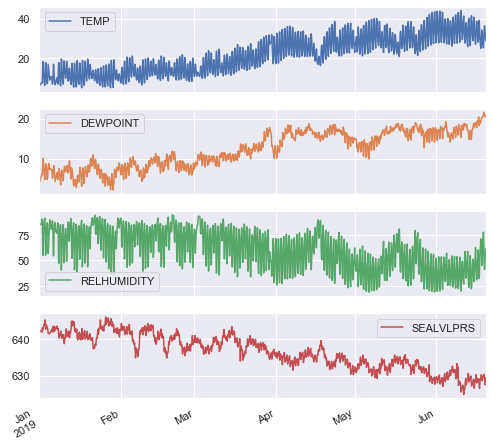

In [9]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

df[['TEMP','DEWPOINT','RELHUMIDITY','SEALVLPRS']].plot(subplots = True, figsize=(8,8))
plt.show()

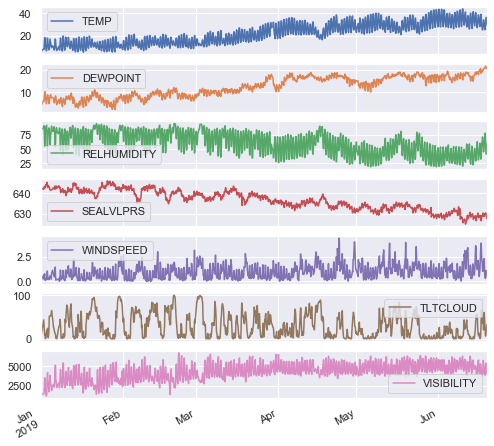

In [3]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

df[['TEMP','DEWPOINT','RELHUMIDITY','SEALVLPRS','WINDSPEED','TLTCLOUD','VISIBILITY']].plot(subplots = True, figsize=(8,8))
plt.show()

A time series plot of our explanatory variables show that trends can be seen in TEMP, DEWPOINT, RELHUMIDITY and SEALVLPRS. To investigate further, we have to run the Augmented Dickey-Fuller test which checks at a 5% significance level if our variables are stationary.

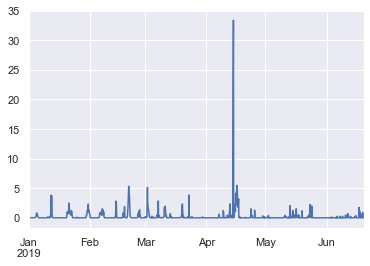

In [10]:
df.RAIN2.plot()
plt.show()

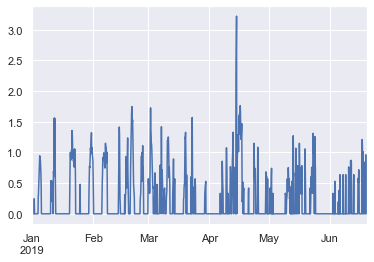

In [11]:
df[['RAIN2']] = np.cbrt(df[['RAIN2']])
df.RAIN2.plot()
plt.show()

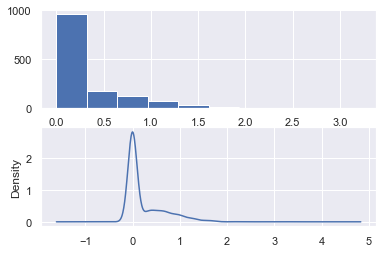

In [12]:
plt.figure()
plt.subplot(211)
df.RAIN2.hist(ax=plt.gca())
plt.subplot(212)
df.RAIN2.plot(kind='kde', ax=plt.gca())
plt.show()

In [5]:
## checking if data is stationary
from statsmodels.tsa.stattools import adfuller

for name, values in df.iteritems():
    result = adfuller(values)
    print('p-value for %s: %4f' % (name,result[1]))

p-value for RAIN2: 0.000000
p-value for TEMP: 0.673552
p-value for DEWPOINT: 0.647437
p-value for RELHUMIDITY: 0.106152
p-value for SEALVLPRS: 0.545265
p-value for WINDSPEED: 0.000000
p-value for DIRECTION: 0.000000
p-value for TLTCLOUD: 0.000000
p-value for VISIBILITY: 0.017265
p-value for RAIN: 0.000000


From the Augmented Dickey-Fuller test, we can confirm our suspicions that TEMP, DEWPOINT, RELHUMIDITY and SEALVLPRS are indeed non-stationary as shown by their respecting p-values > 0.05. The test also shows that our rain obsertion is stationary. However, intuition suggests that whenever there is any heavy rain i.e. a big spike in the time series plot, the mean and variance will change according to the heavy rain. This will not be stationary as the mean and variance will not be constant.  

To ensure model stability, we will apply differencing to all our variables.

In [13]:
# differencing our dataset
diff = pd.DataFrame(index = df.index)
for col in df.columns:
    diff[col] = df[col].diff()
    
diff = diff.iloc[1:]

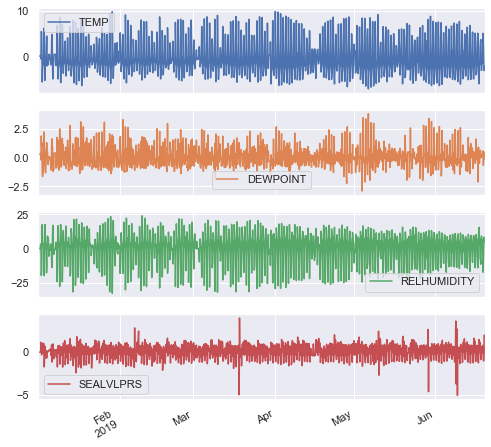

In [7]:
diff[['TEMP','DEWPOINT','RELHUMIDITY','SEALVLPRS']].plot(subplots = True, figsize=(8,8))
plt.show()

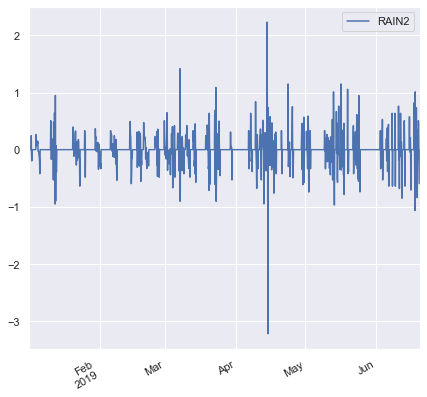

In [14]:
diff[['RAIN2']].plot(subplots = True, figsize=(7,7))
plt.show()

In [ ]:
for name, values in diff.iteritems():
    result = adfuller(values)
    print('p-value for %s: %4f' % (name,result[1]))

Checking the Augmented Dickey-Fuller test shows that all our variables are significant at a 5% level (p-value < 0.05), indicating that they are all stationary.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(diff.RAIN2, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff.RAIN2, ax=plt.gca())
plt.show()

The ACF and PACF plot, allows us to set an initial p and q value for our ARIMA model. From the plots it seems that we can start with p = 3 and q = 3.

In [ ]:
## keep 7 days of data for validation
## translates to 7 days * 8 rows of data for each day
train = diff['2019-01-01':'2019-04-14']
test = diff['2019-04-15':'2019-04-21']
# print(train.shape, test.shape)

In [ ]:
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(endog = train[['RAIN2']],
           order=(3,3), freq='3H')
res = mod.fit(disp = 0)
print(res.summary())

Since our data is already stationary, we will use the ARMA model instead of the ARIMA model. Running an ARMA model without any explanatory variables and p = 3 and q = 3 gives an AIC value of 3770.045.  

The next step is to select which variables to add to our model. By doing stepwise regression with both forward and backwards selection and finding the minimum AIC value as our evaluation method, we find that a model with 'TLTCLOUD' and 'DEWPOINT' as the explanatory variables gives the smallest AIC value of 3747.652. Adding an intercept to the model makes both explanatory variables significant at a 5% level.

In [ ]:
train.columns

In [ ]:
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(endog = train[['RAIN2']], exog = train[['DEWPOINT','RELHUMIDITY','SEALVLPRS','WINDSPEED',
                                                   'TLTCLOUD']],
           order=(3,3), freq='3H')
res = mod.fit(trend="nc", disp = 0)
print(res.summary())

#### Checking Residuals

Checking the residuals of our model involves fitting our model and comparing the actual rain observation from the training set with our model's predicted values. Since our data was already differenced when we fed it into our model, the predicted values are also differenced. Therefore, we have to apply inverse differencing to revert first order differencing.

In [ ]:
## inverse differencing
def inv_diff(df, diff):
    ## prepare DataFrame
    inv_df = pd.DataFrame()
    inv_df['actual_rain'] = df
    inv_df['pred_rain'] = np.append(np.nan, diff)
    
#     x, x_diff = inv_df['actual_rain'].iloc[0], inv_df['pred_rain'].iloc[1:]
#     inv_df['inv_pred_rain'] = np.r_[x, x_diff].cumsum()
    
    ## add actual value with difference
    shifted = df.shift(1)
    inv_df['inv_pred_rain'] = shifted + inv_df['pred_rain']
    ## first row is null, change it to the first value of actual_rain
    inv_df.inv_pred_rain.fillna(df.iloc[0], inplace = True)
    ## round up to 2 decimal places
    inv_df['inv_pred_rain'] = inv_df.inv_pred_rain.round(2)
    
    return inv_df
    

In [ ]:
pred_rain = res.predict()
actual_rain = df['2019-01-01':'2019-04-14'].iloc[:,0]
inverted_df = inv_diff(actual_rain, res.predict())
inverted_df.head()

In [ ]:
### CHECKING RESIDUALS
# errors
residuals = inverted_df['actual_rain'] - inverted_df['inv_pred_rain']
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The plot shows that the errors are normally distributed

#### Grid Search

The next step is to search for the optimal p and q values for our ARMA model. We can achieve this by applying grid search which fits an ARMA model with every possible combination of p and q values, and find the combination that has the lowest RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(df, train, arma_order):
    mod = ARMA(endog = train[['RAIN2']], exog = train[['DEWPOINT','RELHUMIDITY','SEALVLPRS','WINDSPEED','TLTCLOUD']],
           order=arma_order, freq='3H')
    res = mod.fit(trend="nc", disp = 0)
    pred_rain = res.predict()
    actual_rain = df['2019-01-01':'2019-04-14'].iloc[:,0]
    inverted_df = inv_diff(actual_rain, res.predict())
    mse = mean_squared_error(inverted_df.actual_rain, inverted_df.inv_pred_rain)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(df, train, p_range, q_range):
    best_score, best_cfg = float("inf"), None
    for p in p_range:
        for q in q_range:
            order = (p,q)
            try:
                mse = round(evaluate_arima_model(df, train, order), 3)
                print('ARMA%s RMSE=%.3f' % (order,mse))
                if mse < best_score:
                    best_score, best_cfg = mse, order
            except:
                continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# read data
df = pd.read_csv('stations_punjab_hour.csv', index_col = 0)
df.set_index(pd.to_datetime(df.index), inplace = True)

# apply cube root transformation to response
df[['RAIN2']] = np.cbrt(df[['RAIN2']])

# differencing our dataset
diff = pd.DataFrame(index = df.index)
for col in df.columns:
    diff[col] = df[col].diff()
diff = diff.iloc[1:]

# keep last 7 days of data for validation
# translates to 7 days * 8 rows of data for each day
train = diff['2019-01-01':'2019-04-14']
test = diff['2019-04-15':'2019-04-21']

# grid search to find optimal p and q values
p_range = range(0,7)
q_range = range(0,7)
warnings.filterwarnings("ignore")
evaluate_models(df, train, p_range, q_range)

Checking all possible combinations of p and q from 0 to 6 shows that there are a few combination that has the least RMSE of 1.007. we will pick p = 4 and q = 6 as our optimal parameters. Hence, our final model is an ARMA model with explanatory variables "TLTCLOUD" and "DEWPOINT" with parameters p = 4, q = 6.

In [ ]:
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(endog = train[['RAIN2']], exog = train[['DEWPOINT','RELHUMIDITY','SEALVLPRS','WINDSPEED','TLTCLOUD']],
           order=(6,2), freq='3H')
res = mod.fit(trend="nc", disp = 0)
print(res.summary())

#### Out-of-Sample Forecasting

In [ ]:
# read data
df = pd.read_csv('stations_punjab_hour.csv', index_col = 0)
df.set_index(pd.to_datetime(df.index), inplace = True)

# apply cube root transformation to response
df[['RAIN2']] = np.sqrt(df[['RAIN2']])

# differencing our dataset
diff = pd.DataFrame(index = df.index)
for col in df.columns:
    diff[col] = df[col].diff()
diff = diff.iloc[1:]

# keep last 7 days of data for validation
# translates to 7 days * 8 rows of data for each day
train = diff['2019-01-01':'2019-04-14']
test = diff['2019-04-15':'2019-04-21']

In [ ]:
# ARIMA model
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(endog = train[['RAIN2']], exog = train[['DEWPOINT','RELHUMIDITY','SEALVLPRS','WINDSPEED','TLTCLOUD']],
           order=(6,2), freq='3H')
res = mod.fit(trend="nc", disp = 0)

## forecast 7 days of rainfall
## since our data is 3 hourly it is 7 * 8 rows of observation to forecast
pred_rain = res.forecast(steps=56,exog=test[['DEWPOINT','RELHUMIDITY','SEALVLPRS','WINDSPEED','TLTCLOUD']])[0]
actual_rain = df['2019-04-14 21:00:00':'2019-04-21 21:00:00'].iloc[:,0]
inverted_df = inv_diff(actual_rain, pred_rain)
inverted_df.head()

The inverse differenced forecasted rain values show that the model has mostly predicted close to 0mm of rainfall. Since heavy rainfall is so scarce (our test set only contains 4 observations of rainfall), it is hard to feed in good data to forecast heavy rains using our current model. It also seems that our model has predicted some negative values as well, which is not what we want. 

In [ ]:
## classify rain to be 1 if heavy rain and 0 if not
accuracy_df = pd.DataFrame()
accuracy_df['TRUE_RAIN'] = [1 if x >= 1.5 else 0 for x in inverted_df['actual_rain']] 
accuracy_df['PRED_RAIN'] = [1 if x >= 1.5 else 0 for x in inverted_df['inv_pred_rain']]
accuracy_df = accuracy_df[accuracy_df.TRUE_RAIN == 1]
accuracy_df

In [ ]:
from sklearn.metrics import accuracy_score
print('Model accuracy for predicting heavy rainfall:', accuracy_score(accuracy_df.TRUE_RAIN, accuracy_df.PRED_RAIN, normalize = True))
print('Number of correctly classified samples:', accuracy_score(accuracy_df.TRUE_RAIN, accuracy_df.PRED_RAIN, normalize = False))

Checking our model accuracy given that TRUE_RAIN == 1 gives a 70% accuracy for our model i.e. our model predicted heavy rain for 7 out of 10 actual observations.